# Predict house prices: regression

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to predict a discrete label (for example, where a picture contains an apple or an orange). 

This notebook builds a model to predict the median price of homes in a Boston suburb during the mid-1970s. To do this, we'll provide the model with some data points about the suburb, such as the crime rate and the local property tax rate.

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
tf.keras.backend.clear_session()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
temp=os.getpid()
!kill -9 $temp
#!nvidia-smi -q -d PIDS | grep -P "Process ID +: [0-9]+" | grep -Po "[0-9]+" | xargs kill -9
keras.__version__



'2.2.4-tf'

## The Boston Housing Prices dataset

This [dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) is accessible directly in Keras. Download and shuffle the training set:

In [2]:
boston_housing = keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# Shuffle the training set
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

### Examples and features

This dataset is much smaller than the others we've worked with so far: it has 506 total examples are split between 404 training examples and 102 test examples:

In [3]:
print("Training set: {}".format(train_data.shape))  # 404 examples, 13 features
print("Testing set:  {}".format(test_data.shape))   # 102 examples, 13 features

Training set: (404, 13)
Testing set:  (102, 13)


The dataset contains 13 different features:

1.   Per capita crime rate.
2.   The proportion of residential land zoned for lots over 25,000 square feet.
3.   The proportion of non-retail business acres per town.
4.   Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5.   Nitric oxides concentration (parts per 10 million).
6.   The average number of rooms per dwelling.
7.   The proportion of owner-occupied units built before 1940.
8.   Weighted distances to five Boston employment centers.
9.   Index of accessibility to radial highways.
10.  Full-value property-tax rate per \\$10,000.
11.  Pupil-teacher ratio by town.
12.  1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13.  Percentage lower status of the population.

Each one of these input data features is stored using a different scale. Some features are represented by a proportion between 0 and 1, other features are ranges between 1 and 12, some are ranges between 0 and 100, and so on. This is often the case with real-world data, and understanding how to explore and clean such data is an important skill to develop.

Key Point: As a modeler and developer, think about how this data is used and the potential benefits and harm a model's predictions can cause. A model like this could reinforce societal biases and disparities. Is a feature relevant to the problem you want to solve or will it introduce bias? For more information, read about [ML fairness](https://developers.google.com/machine-learning/fairness-overview/).

In [4]:
print(train_data[0])  # Display sample features, notice the different scales

[7.8750e-02 4.5000e+01 3.4400e+00 0.0000e+00 4.3700e-01 6.7820e+00
 4.1100e+01 3.7886e+00 5.0000e+00 3.9800e+02 1.5200e+01 3.9387e+02
 6.6800e+00]


Use the [pandas](https://pandas.pydata.org) library to display the first few rows of the dataset in a nicely formatted table:

In [5]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.07875,45.0,3.44,0.0,0.437,6.782,41.1,3.7886,5.0,398.0,15.2,393.87,6.68
1,4.55587,0.0,18.10,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12
2,0.09604,40.0,6.41,0.0,0.447,6.854,42.8,4.2673,4.0,254.0,17.6,396.90,2.98
3,0.01870,85.0,4.15,0.0,0.429,6.516,27.7,8.5353,4.0,351.0,17.9,392.43,6.36
4,0.52693,0.0,6.20,0.0,0.504,8.725,83.0,2.8944,8.0,307.0,17.4,382.00,4.63


### Labels

The labels are the house prices in thousands of dollars. (You may notice the mid-1970s prices.)

In [6]:
print(train_labels[0:10])  # Display first 10 entries

[32.  27.5 32.  23.1 50.  20.6 22.6 36.2 21.8 19.5]


## Normalize features

It's recommended to normalize features that use different scales and ranges. For each feature, subtract the mean of the feature and divide by the standard deviation:

In [7]:
# Test data is *not* used when calculating the mean and std

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

print(train_data[0])  # First training sample, normalized

[-0.39725269  1.41205707 -1.12664623 -0.25683275 -1.027385    0.72635358
 -1.00016413  0.02383449 -0.51114231 -0.04753316 -1.49067405  0.41584124
 -0.83648691]


Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model more dependent on the choice of units used in the input.

## Create the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [8]:
def build_model():
        model = keras.Sequential([
        keras.layers.Dense(64, activation='relu',input_shape=(train_data.shape[1],)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)   ])

        optimizer = keras.optimizers.Adam(lr=0.001)

        model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
        return model

model = build_model()
model.summary()

W1009 00:14:55.915040 35184372383184 deprecation.py:506] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


## Train the model

The model is trained for 500 epochs, and record the training and validation accuracy in the `history` object.

In [9]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Visualize the model's training progress using the stats stored in the `history` object. We want to use this data to determine how long to train *before* the model stops making progress.

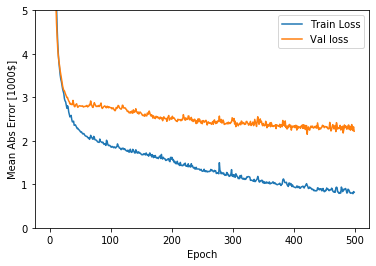

In [10]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 5])

plot_history(history)

This graph shows little improvement in the model after about 200 epochs. Let's update the `model.fit` method to automatically stop training when the validation score doesn't improve. We'll use a *callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://keras.io/callbacks/#earlystopping).


....................................................................................................
....................................................................................................
..................................................

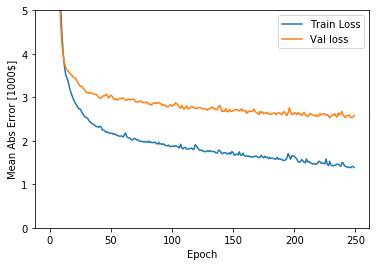

In [11]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

The graph shows the average error is about \\$2,500 dollars. Is this good? Well, \\$2,500 is not an insignificant amount when some of the labels are only \\$15,000.

Let's see how did the model performs on the test set:

In [12]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

Testing set Mean Abs Error: $2672.98


## Predict

Finally, predict some housing prices using data in the testing set:

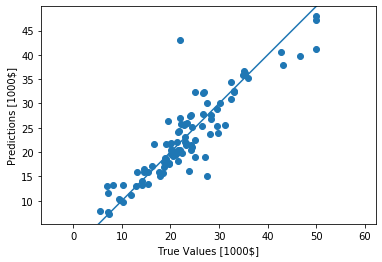

In [13]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [1000$]')
plt.ylabel('Predictions [1000$]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])


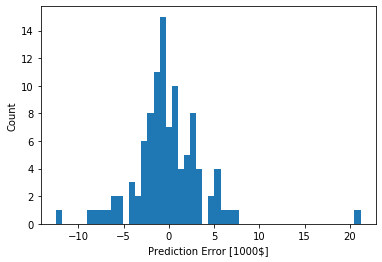

In [14]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [1000$]")
_ = plt.ylabel("Count")

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different than classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When input data features have values with different ranges, each feature should be scaled independently.
* If there is not much training data, prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.

In [15]:
!jupyter notebook list

Currently running servers:
http://0.0.0.0:48557/jupyter/user/s1228964/ :: /home/h0/s1228964


In [16]:
!lsof -n -i4TCP:[port-number]

lsof: unknown service [port-number] for tcp in: -i 4TCP:[port-number]
lsof 4.87
 latest revision: ftp://lsof.itap.purdue.edu/pub/tools/unix/lsof/
 latest FAQ: ftp://lsof.itap.purdue.edu/pub/tools/unix/lsof/FAQ
 latest man page: ftp://lsof.itap.purdue.edu/pub/tools/unix/lsof/lsof_man
 usage: [-?abhKlnNoOPRtUvVX] [+|-c c] [+|-d s] [+D D] [+|-f[gG]] [+|-e s]
 [-F [f]] [-g [s]] [-i [i]] [+|-L [l]] [+m [m]] [+|-M] [-o [o]] [-p s]
[+|-r [t]] [-s [p:s]] [-S [t]] [-T [t]] [-u s] [+|-w] [-x [fl]] [--] [names]
Use the ``-h'' option to get more help information.


177602

0